Tutorial
===========

In [48]:
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import matplotlib.pyplot as plt

G=nx.Graph()
G.add_node(1)
G.add_nodes_from([2,3])
G.number_of_nodes()


3

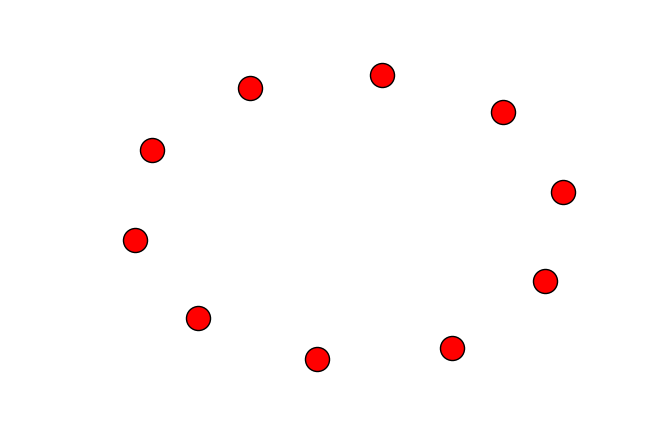

In [2]:
# Use path_graph
G.clear()
G = nx.Graph()
H = nx.path_graph(10)
G.add_nodes_from(H)

nx.draw(G)
plt.show()

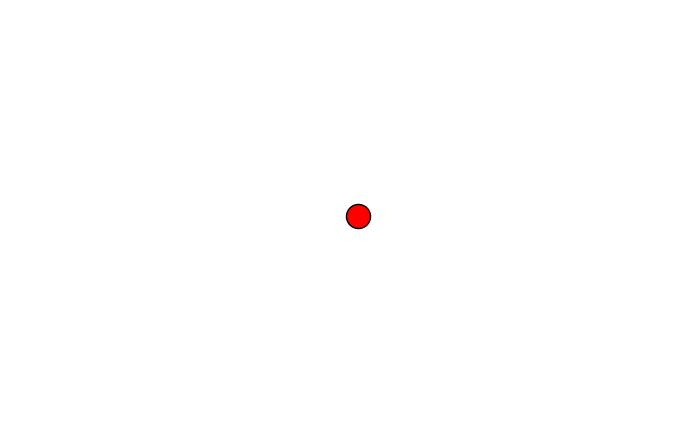

In [6]:
# Use path_graph, adding as node
G.clear()
G = nx.Graph()
H = nx.path_graph(10)
G.add_node(H)

nx.draw(G)
plt.show()

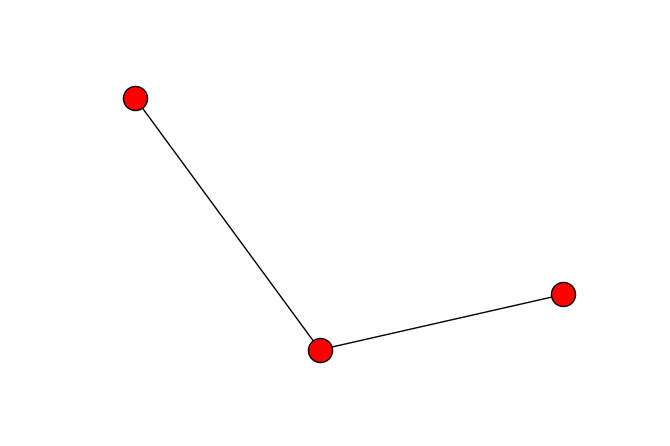

In [12]:
# Add edges
G.clear()
G.add_nodes_from([1,3])
G.add_edge(1,2)
e = (2,3)
G.add_edge(*e)
nx.draw(G)
plt.show()

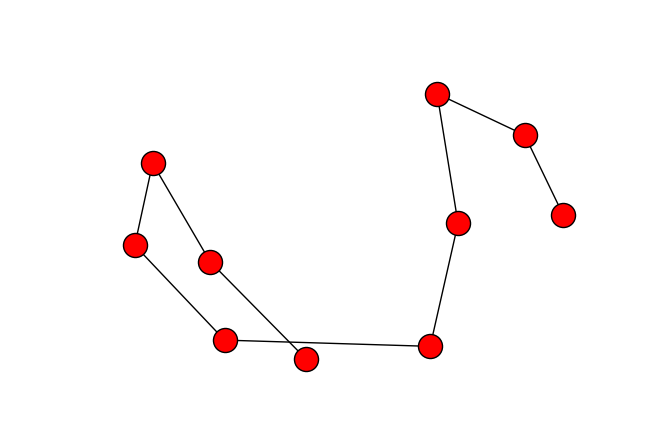

In [14]:
# Add edges from ebunch
G.clear()
G.add_edges_from(H.edges())
nx.draw(G)
plt.show()

In [16]:
G.number_of_nodes()

9

In [17]:
G.number_of_edges()

9

In [19]:
G.add_node("carne")
G.add_nodes_from("sangre")
G.nodes()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'n', 'carne', 'a', 's', 'e', 'g', 'r']

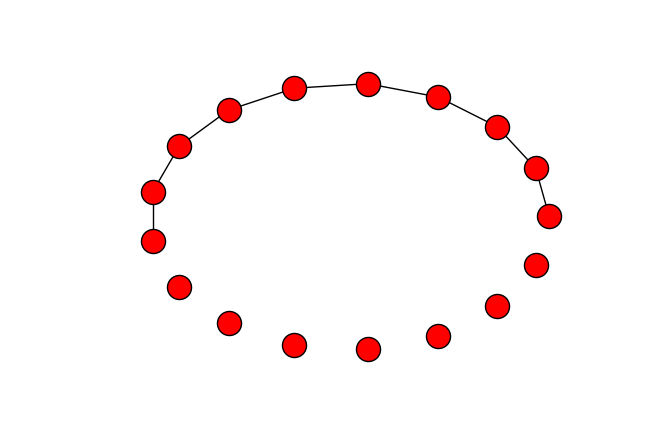

In [26]:
nx.draw_circular(G)
plt.show()

Graph generation
=====================

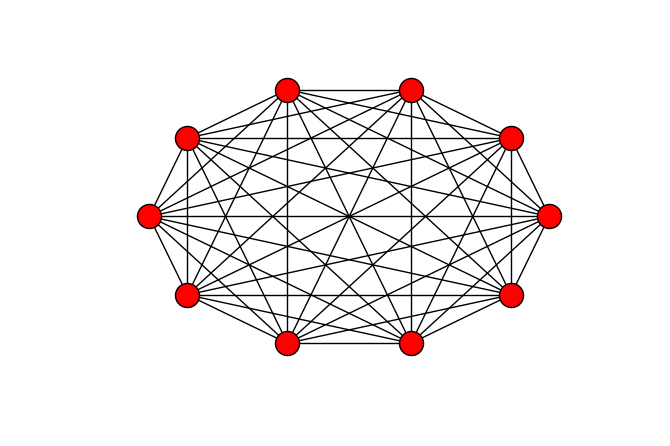

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [41]:
G = nx.complete_graph(10)
nx.draw_circular(G)
plt.show()

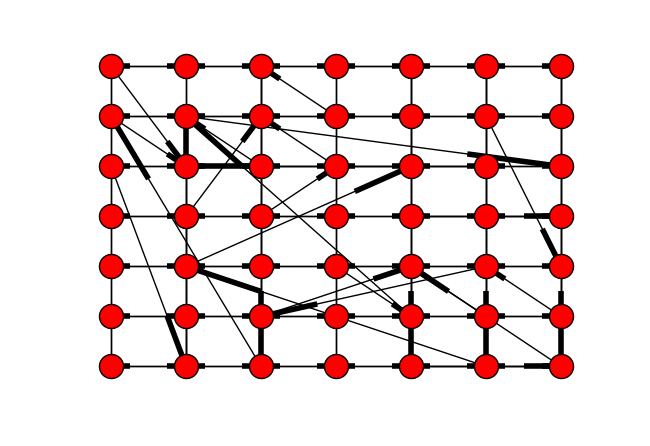

In [159]:
G = nx.navigable_small_world_graph(7, p=1, q=1, r=2, dim=2)
#nx.draw_networkx(G, pos=dict(zip(G,G)))
nx.draw(G, pos=dict(zip(G,G)))
plt.show()

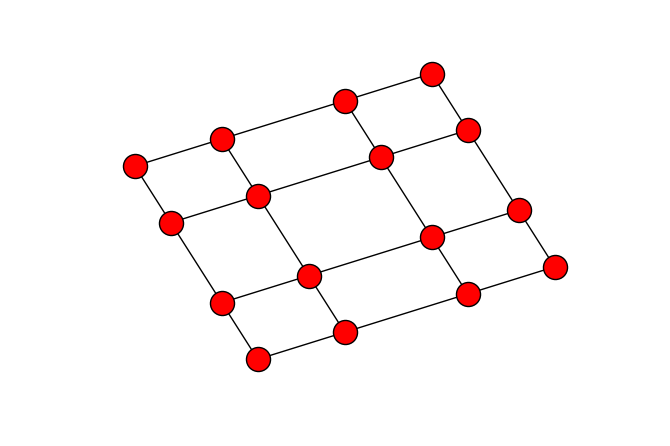

In [52]:
G = nx.grid_2d_graph(4,4)
nx.draw_spectral(G)
plt.show()

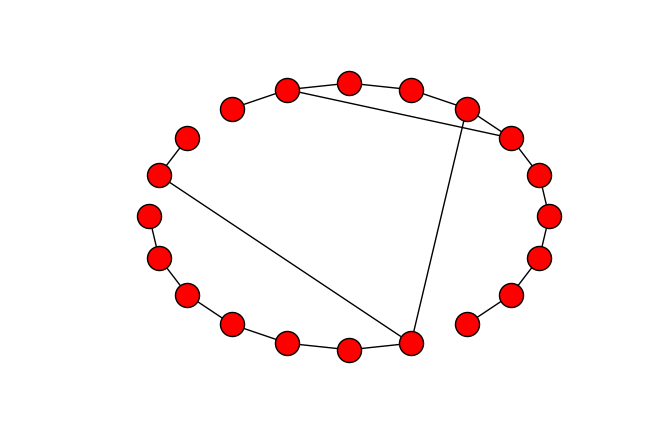

In [63]:
G = nx.watts_strogatz_graph(20, 3, 0.1)
nx.draw_circular(G)
plt.show()

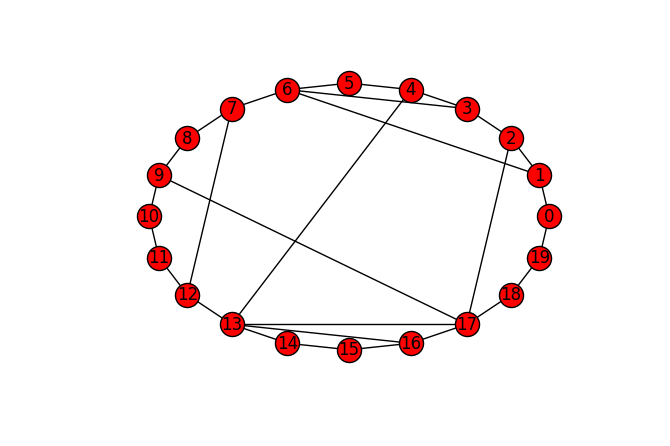

[1, 2, 17, 9, 10]

In [63]:
G = nx.newman_watts_strogatz_graph(20, 3, 0.3)
nx.draw_circular(G, with_labels=True)
plt.show()
G.nodes()
nx.shortest_path(G, 1, 10)



In [23]:
# Use graphviz
G = nx.complete_graph(10)
A = nx.nx_agraph.to_agraph(G)
A.layout()
# prog=[neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp.]
A.draw('graph.ps', prog='circo')

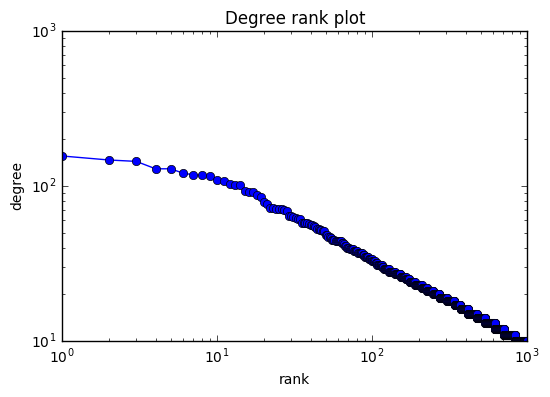

In [167]:
G=nx.Graph()
G = nx.barabasi_albert_graph(1000, 10)
#nx.draw_circular(G, with_labels=True, node_size=200)
#plt.show()

degree_sequence=sorted(nx.degree(G).values(),reverse=True)
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

Greedy Routing
==================

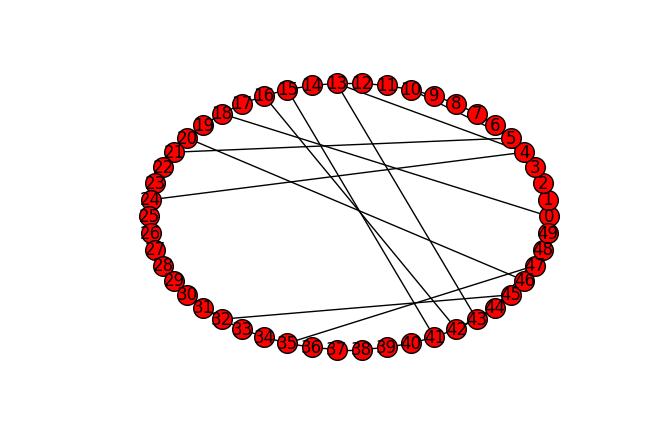

In [37]:
G = nx.newman_watts_strogatz_graph(50, 3, 0.3)
nx.draw_circular(G, with_labels=True, node_size=200)
plt.show()

Kleinberg's Model with Ring topology
====================================

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

from utils.gen import navigable_small_world_ring
from utils.search import greedy_path

[(0, 1), (0, 19), (0, 17), (1, 16), (1, 2), (1, 19), (2, 3), (2, 17), (3, 8), (3, 4), (3, 5), (3, 7), (4, 5), (5, 6), (6, 10), (6, 7), (7, 8), (7, 10), (7, 7), (8, 9), (9, 17), (9, 10), (9, 11), (10, 11), (11, 12), (12, 17), (12, 13), (13, 18), (13, 14), (14, 14), (14, 15), (15, 16), (15, 15), (16, 17), (17, 18), (18, 19), (19, 19)]
current node is 0
current node is 1
current node is 2
current node is 3
[0, 1, 2, 3, 5]


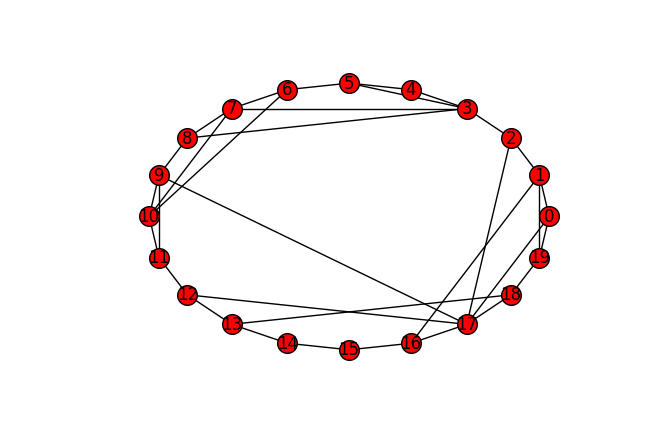

In [39]:
G = navigable_small_world_ring(20, p=1, q=1, r=1)
print(G.edges())
nx.draw_circular(G, with_labels=True, node_size=200)
print(greedy_path(G, 0, 5))
plt.show()